# Digital Signal Processing for Speech, Language, & Hearing Sciences 
# Tutorial 2: Acoustic Measurement and Manipulation

**Meg Cychosz**, *University of Maryland-College Park & UCLA*

## Table of Contents
1. [Amplitude: Measurement](#measurement)
    1. [Conversion](#conversion)
    2. [Amplitude fades and modulation](#fades)
    3. [Amplitude and sound localization](#localization)
2. [Amplitude: Manipulation](#manipulation)

In the previous tutorial we covered the basics of audio digitization and some forms of measurement. In this tutorial, we'll go into detail about how to take some more detailed acoustic measurements and some basic audio manipulations. 

In [152]:
import os, re
import numpy as np
import librosa as lb
from librosa import display
import matplotlib.pyplot as plt
import scipy as sc
import pydub as pd
from pydub import AudioSegment
import IPython.display as ipd
from IPython.display import Audio

## Amplitude

## Measurement<a name="measurement"></a> 

There are several different measures of amplitude that we may be interested in. We may, for example, be interested in identifying the *highest* or peak amplitude, that sounds the loudest to us. (Though recall that expressions like how "loud" we perceive a signal to be are *psycho*acoustical, not physical, and can be subjective.) 

In [163]:
# read in the sound file
path = os.getcwd()
sound_file, sr = lb.load(path+'/files/limp\'u.wav')
sound_file = sound_file / np.abs(sound_file).max() # scale between -1 and 1

### Conversion<a name="conversion"></a> 

Sometimes we may be interested in converting our unitless, linear amplitude scale (from -1 to 1), which is difficult to interpret numerically, to something more interpretable, like the dB scale as these spectrograms generated using some handy Librosa functions illustrate:

In [104]:
# first get a power spectrogram
S = np.abs(lb.stft(sound_file))
# convert to dB
sound_file_dB = lb.power_to_db(S**2)

print ('range is', np.min(sound_file_dB), 'to', np.max(sound_file_dB), 'dB')

range is -30.637932 to 49.36207 dB


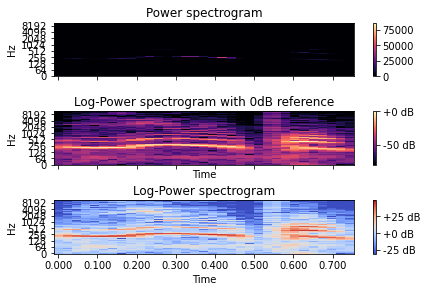

In [120]:
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
imgpow = lb.display.specshow(S**2, sr=sr, y_axis='log', x_axis='time',
                                   ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
imgdbref = lb.display.specshow(lb.power_to_db(S**2, ref=np.max),
                                  sr=sr, y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Log-Power spectrogram with 0dB reference')
imgdb = lb.display.specshow(lb.power_to_db(S**2),
                                  sr=sr, y_axis='log', x_axis='time', ax=ax[2])
ax[2].set(title='Log-Power spectrogram')

fig.colorbar(imgpow, ax=ax[0])
fig.colorbar(imgdbref, ax=ax[1], format="%+2.0f dB")
fig.colorbar(imgdb, ax=ax[2], format="%+2.0f dB")
fig.tight_layout(pad=.5)

We can also convert between scales by hand when we plot:

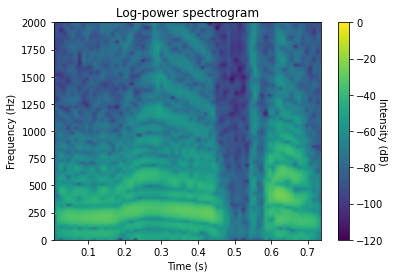

In [121]:
f, t, i = sc.signal.spectrogram(sound_file, sr, nfft=1028)
plt.pcolormesh(t, f, 10*np.log10(i), shading='gouraud',vmin=-120, vmax=0) # convert to dB
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Log-power spectrogram')
plt.ylim(0,2000)
plt.colorbar().set_label('Intensity (dB)', rotation=270)

## Manipulation<a name="manipulation"></a>  

There are a variety of amplitude measures that we may want to query. We can take the absolute value of each amplitude sample and identify the highest value in the array:

In [122]:
max = np.round((np.amax(np.abs(sound_file_dB))),2)
print (max,'dB')

49.36 dB


We may also be interested in measuring the *overall* amplitude of a signal. To measure that, we compute the root mean square (RMS) amplitude. We can do this using Librosa functions such as 'feature.rms', but it's fun to see the underlying math so we'll do it by hand:

In [123]:
# we square each amplitude sample in the array, average them, and take the square root:
rms = np.round((np.sqrt(np.mean(sound_file_dB**2))),2)
print (rms,'dB')

21.45 dB


We may likewise be interested in increasing or decreasing our amplitude. Perhaps we wish to specify a particular number of decibels to increase or decrease the *overall* amplitude of the signal.

Let's assume that we want to increase the amplitude of our sound file by 12 dB. (+6 dB doubles the amplitude of the signal, +12 quadruples etc.) Remember that altering the amplitude in this way doesn't necessarily mean that the sound will appear as many times as loud to our ears because perceived "loudness" is a complex psychological phenomenon that incorporates amplitude but also the frequency and temporal structure of a sound, as well as one's length of exposure to it. 

The Pydub library makes these sorts of gain manipulations incredibly easy:

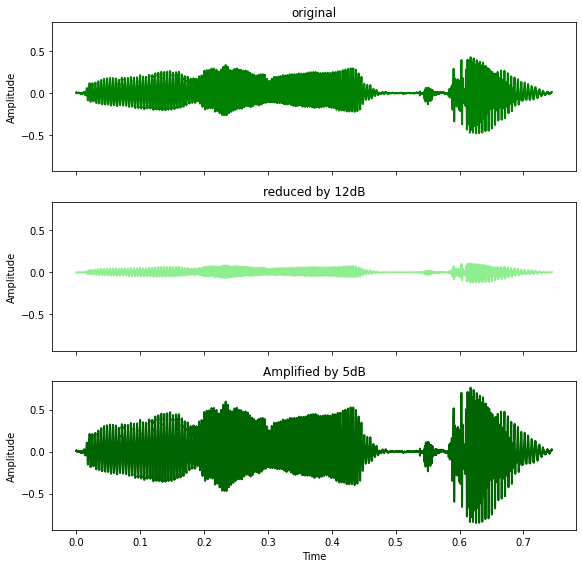

In [173]:
# first we create an audiosegment object
sound_file = AudioSegment.from_wav(path+'/files/limp\'u.wav')

# and then it is easy to manipulate the gain
# reduce the entire signal by 12dB
quieter = sound_file - 12
# amplify the entire signal by 5dB
louder = sound_file + 5

# play the output 
sound_file
quieter
louder

# save the output
sound_file.export(path+"/files/og.wav", "wav")
quieter.export(path+"/files/quieter.wav", "wav")
louder.export(path+"/files/louder.wav", "wav")

# read output back in and visualize 
sound_file, sr = lb.load(path+'/files/og.wav')
quieter, sr = lb.load(path+'/files/quieter.wav')
louder, sr = lb.load(path+'/files/louder.wav')
t = np.linspace(0, len(sound_file) / sr, num=len(sound_file)) # x values

fig, axs = plt.subplots(3,1,figsize=(8,8),sharex=True, sharey=True)
axs[0].plot(t,sound_file,'green',lw=2) 
axs[0].set_title('original') 
axs[1].plot(t,quieter,'lightgreen',lw=2)
axs[1].set_title('reduced by 12dB') 
axs[2].plot(t,louder,'darkgreen',lw=2)
axs[2].set_title('Amplified by 5dB') 
plt.xlabel('Time')
fig.tight_layout()

for ax in axs.flat:
    ax.set(ylabel='Amplitude')

### Amplitude fades and modulation<a name="fades"></a> 

Sometimes we don't want to manipulate the overall amplitude of a signal, but just the beginning or the end. For example, we may wish to gradually increase the amplitude at the beginning of a signal, and decrease it at the end. To accomplish this amplitude fading, we will compute various functions (linear, quadratic, exponential) and multiply them by the signal:

In [179]:
t_int = int(sr*lb.get_duration(y=sound_file)) # integer indicating the num of samples

# linear fade in
lin_fade = np.linspace(0,1,t_int) # array from 0 to 1 with t samples
sound_lin = np.multiply(lin_fade,sound_file)

# quadratic fade in
sound_quad = np.multiply((np.linspace(0,1,t_int)**2),sound_file)

# exponential fade in
sound_exp = np.multiply((np.logspace(0,1,t_int)),sound_file)

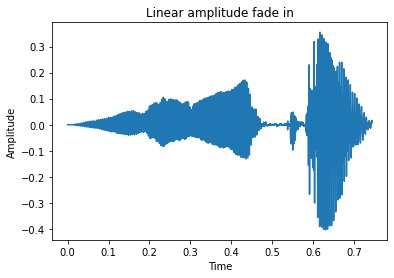

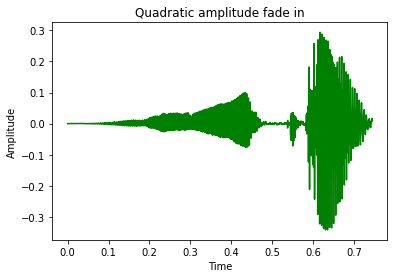

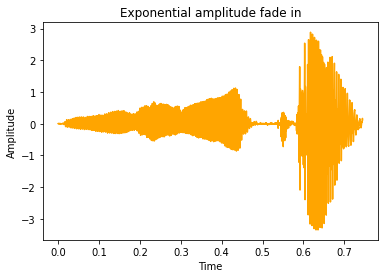

In [180]:
t = np.linspace(0, len(sound_file) / sr, num=len(sound_file)) # x values

Audio(data=sound_lin,rate=sr)

plt.figure()
plt.plot(t,sound_lin)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title("Linear amplitude fade in")
plt.show()

Audio(data=sound_quad,rate=sr)

plt.figure()
plt.plot(t,sound_quad,c="green")
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title("Quadratic amplitude fade in")
plt.show()

Audio(data=sound_exp,rate=sr)

plt.figure()
plt.plot(t,sound_exp,c="orange")
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title("Exponential amplitude fade in")
plt.show()

In [181]:
# linear fade out 
# we reverse the integer order in the fade array from 1 to 0
sound_lin_out = np.multiply((np.linspace(1,0,t_int)),sound_file)

# apply linear fade in to first 25% of signal
# here I've created two different arrays: one increasing for the first 25% and the static 
# and I concatenate it with an array of 1s for the remaining 75% of the sample length
short_lin_fade = np.concatenate([np.linspace(0,1,int(t_int/4)),np.linspace(1,1,(t_int-int(t_int/4)))]) # ramp for the first 25% of signal
short_lin_sound = np.multiply(short_lin_fade,sound_file)

# both linear fade in and out
# same idea but 3 arrays are concatenated 
lin_in_out = np.concatenate([np.linspace(0,1,int(t_int/4)),np.linspace(1,1,(t_int-(2*int(t_int/4)))),np.linspace(1,0,int(t_int/4))]) # ramp for the first and last 25% of signal
lin_in_out_sound = np.multiply(lin_in_out,sound_file)

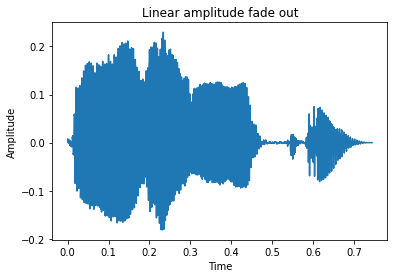

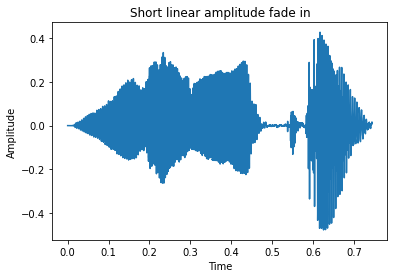

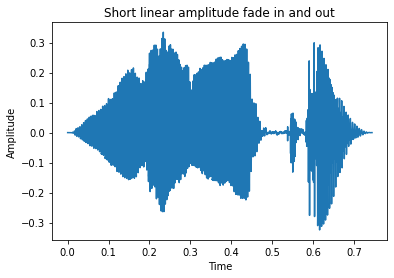

In [182]:
Audio(data=sound_lin_out,rate=sr)

plt.figure()
plt.plot(t,sound_lin_out)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title("Linear amplitude fade out")
plt.show()

Audio(data=short_lin_sound,rate=sr)

plt.figure()
plt.plot(t,short_lin_sound)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title("Short linear amplitude fade in")
plt.show()

Audio(data=lin_in_out_sound,rate=sr)

plt.figure()
plt.plot(t,lin_in_out_sound)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title("Short linear amplitude fade in and out")
plt.show()

In fact, we can apply this same technique to modify the amplitude throughout the signal in amplitude modulation:

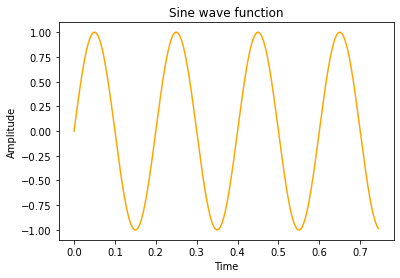

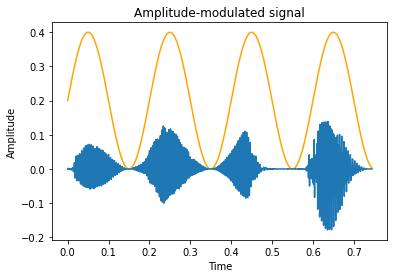

In [183]:
sf = np.sin(t*(2*np.pi)*5) # compute any low-frequency sine wave function; this is our low-frequency oscillator (LFO)

plt.figure()
plt.plot(t,sf,c="orange")
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title("Sine wave function")
plt.show()

# but we don't want any negative values 

sf2 = (sf + 1)*.2 # apply DC offset and reduce the overall amp

Audio(data=np.multiply(sf2,sound_file),rate=sr) # multiply the sine function by the signal
plt.figure()
plt.plot(t,sf2,c="orange")
plt.plot(t,np.multiply(sf2,sound_file))
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title("Amplitude-modulated signal")
plt.show()

If we want to increase the rate of the modulation, we simply specify a higher-frequency sine wave function: 

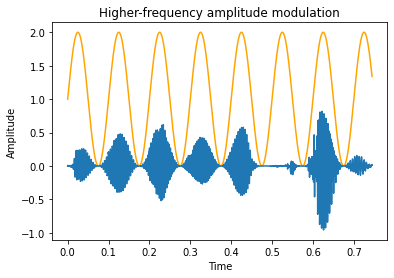

In [184]:
sf_higher = np.sin(t*(2*np.pi)*10) + 1

Audio(data=np.multiply(sf_higher,sound_file),rate=sr) # multiply the sine function by the signal
plt.figure()
plt.plot(t,sf_higher,c="orange")
plt.plot(t,np.multiply(sf_higher,sound_file))
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title("Higher-frequency amplitude modulation")
plt.show()

And if we want to modify the intensity of the modulation, we multiply the sine wave function by a constant:

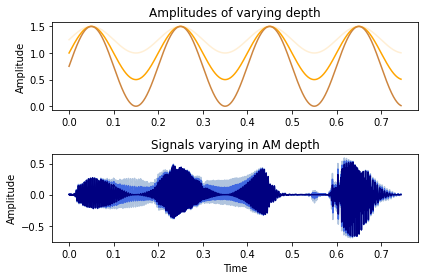

In [185]:
sf_deep = np.sin(t*(2*np.pi)*5)*.25 + 1.25
sf_deeper = np.sin(t*(2*np.pi)*5)*.5 + 1
sf_deepest = np.sin(t*(2*np.pi)*5)*.75 + .75

Audio(data=np.multiply(sf_deep,sound_file),rate=sr)
Audio(data=np.multiply(sf_deeper,sound_file),rate=sr)
Audio(data=np.multiply(sf_deepest,sound_file),rate=sr)

fig, axs = plt.subplots(2)
axs[0].plot(t,sf_deep,'papayawhip')
axs[0].plot(t,sf_deeper,'orange')
axs[0].plot(t,sf_deepest,'peru')
axs[0].set_title('Amplitudes of varying depth')
axs[1].plot(t,np.multiply(sf_deep,sound_file),'lightsteelblue')
axs[1].plot(t,np.multiply(sf_deeper,sound_file),'royalblue')
axs[1].plot(t,np.multiply(sf_deepest,sound_file),'navy')
axs[1].set_title('Signals varying in AM depth')
plt.ylabel('Amplitude')
plt.xlabel('Time')
fig.tight_layout()

for ax in axs.flat:
    ax.set(ylabel='Amplitude')

### Amplitude and sound localization (panning)<a name="localization"></a> 

Another interesting use of amplitude modulation is to incorporate some of our knowledge of mono and stereo sounds to manipulate sound localization. The basic idea is that sounds that are closer to us should be louder. 

First let's load a couple different audio files of infants vocalizing:

In [200]:
baby_sound, sr = lb.load(path+'/files/Cychosz_105_740_1799.98_1801.91.wav') 
baby_sound2, sr = lb.load(path+'/files/Cychosz_105_740_1138.76_1139.83.wav') 

Now create some values to scale the amplitude of each channel by and apply them to the first and second audio signals:

In [201]:
pan = 50 # panning values range from -100 (audio totally from L) to +100 (totally R)
r = pan/200 + 0.5 
l = 1 - r # the inverse of r

stereo_sound2 = np.array([baby_sound*l,baby_sound2*r])
Audio(data=stereo_sound2,rate=sr)

A positive panning value (+50) applied to the infant streaming from the right channel means that we perceive the infant on our right as being closer to us than the infant on our left. We could manipulate the panning value again to make the infant on our left appear closer than the infant on our right: 

In [202]:
stereo_sound3 = np.array([baby_sound*(1 - (-190/200 + 0.5)),baby_sound2*(-190/200 + 0.5)])
Audio(data=stereo_sound3,rate=sr)

The infant on the left sounds so close that you feel like you're holding them on your shoulder!

Sometimes we may not simply want to manipulate the *static* amplitudes of our channels; we may want a dynamic amplitude that changes over the course of the signal. Here the percept is a sound moving across the stereo field. We'll see what that sounds like shortly. 

To create a dynamic panning function, we simply need to multiply our signals by an array instead of a single number as we did for the 'pan' variable above. 

In [198]:
t = np.linspace(0, len(baby_sound) / sr, num=len(baby_sound)) # x values

pan_d = np.sin(t*(2*np.pi)*.25)*100 # low-frequency oscillator (.25 Hz) spanning -100 to +100
r_d = pan_d/200 + 0.5 
l_d = 1 - r_d # the inverse

stereo_sound_d = np.array([np.multiply(baby_sound,l_d),np.multiply(baby_sound,r_d)])
Audio(data=stereo_sound_d,rate=sr)

It sounds like the child is walking across the room in front of you!

In fact, if you wanted to create the *perception* of an older child, you could increase the frequency of your oscillator ('pan_d') making it sound like the child was running across the room in front of you instead of slowly crawling or walking! 

In [199]:
# a running child

r_d2 = np.sin(t*(2*np.pi)*.8)*100/200 + 0.5 # higher-frequency oscillator (.8 Hz) applied
l_d2 = 1 - r_d 

run_child = np.array([np.multiply(baby_sound,l_d2),np.multiply(baby_sound,r_d2)])
Audio(data=run_child,rate=sr)

In reality, we localize sound more via *power* differentials, not amplitude. Additional panning functions, besides the linear one explored here, will allow you to manipulate power. If you're interested in more in-depth exploration of those panning functions, you should check out Eric Tarr's wonderful signal processing resources on hackaudio.com. 